<h1>Machine Learning for Predicting Winter Olympics:</h1>

<img src = "https://d5861f095856377e2601a9eb-grcrmmrywo7o.netdna-ssl.com/wp-content/uploads/2014/02/pyeongchang-2018-on-white.png" width=240>

In [2]:
%matplotlib nbagg 
# inline
import networkx as nx
import os as os
import glob
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import math as mt
from IPython.display import Image 

<h2>1.1. Data Import, Socioeconomics:</h2>

In [3]:
#Read Population of countries
filename = "./Data/Population.csv"
dfs = []
dfs.append(pd.read_csv(filename,delimiter=";",index_col=False))
population = pd.concat(dfs)
population.head(5)

# Read other national metrics
dfs = []
dfs.append(pd.read_csv('./Data/Temperature.csv',delimiter=";",index_col=False))
temperature = pd.concat(dfs)

dfs = []
dfs.append(pd.read_csv('./Data/Elevation.csv',delimiter=";",index_col=False))
elevation = pd.concat(dfs)

dfs = []
dfs.append(pd.read_csv('./Data/GDP.csv',delimiter=";",index_col=False))
gdp = pd.concat(dfs)

# Merge the metrics
new = pd.merge(gdp, elevation, how='outer', on='Country')
metrics = pd.merge(new, temperature, how='outer', on='Country')

print "List of countries without temperature:", metrics[metrics["Temperature"].isnull()]["Code"].tolist()
metrics.head(3)

List of countries without temperature: ['HKG', 'PRI', 'MAC', 'PSE', 'LAO', 'MKD', 'SSD', 'IMN', 'XKX', 'GUM', 'BMU', 'VIR', 'FRO', 'GRL', 'CPV', 'TLS', 'LCA', 'GMB', 'MNP', 'KNA', 'VCT', 'ASM', 'FSM', 'NRU', 'WLD', 'EAS', 'ECS', 'LCN', 'MEA', 'NAC', 'SAS', 'SSF', 'LIC', 'LMC', 'UMC', 'HIC', 'GUF', 'ESH', 'TWN', nan, nan]


,Code,Country,GDP,Elevation,Temperature
0,USA,United States,18036648.0,760.0,8.55
1,CHN,China,11064665.0,184.0,6.95
2,JPN,Japan,4383076.0,438.0,11.15


In [4]:
#Merging the metrics according to merged countries in the Olympics:
## Balkans
metrics["Code"] = metrics["Code"].str.replace("HRV","CRO")
metrics["Code"] = metrics["Code"].str.replace("SVN","SLO")
metrics["Code"] = metrics["Code"].str.replace("CRO","YUG") # "HRV"
metrics["Code"] = metrics["Code"].str.replace("SLO","YUG")

# Czechoslovakia
metrics["Code"] = metrics["Code"].str.replace("SVK","TCH") 
metrics["Code"] = metrics["Code"].str.replace("CZE","TCH") 

# Merging the metrics of two countries which share a united code 
metrics = metrics.groupby(["Code"]).agg({"GDP"         : "sum",
                                         "Elevation"   : "mean",
                                         "Temperature" : "mean",
                                         "Country" : lambda x: '-'.join(x),
                                         }).reset_index()

metrics.head(5)
metrics[metrics['Code'].isin(["GER", "YUG", "TCH"])]

,Code,GDP,Country,Elevation,Temperature
66,GER,3363447.0,Germany,263.0,8.500
184,TCH,272420.0,Czech Republic-Slovakia,445.5,7.175
212,YUG,91507.0,Croatia-Slovenia,411.5,9.900


<h2>1.2. Data Import: Medal Tables</h2>

In [5]:
# Read Olympics Medals 
path = "./Data/Winter/"

filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) & f.endswith('.csv')]
filenames = [s.strip('.csv') for s in filenames]

dfs = []
for filename in filenames:
    a = pd.read_csv(path+filename+'.csv',delimiter=";",names=["Country", "Code","Gold","Silver","Bronze"])
    a["Year"] = int(filename)
    dfs.append(a)

df = pd.concat(dfs)
df["Host"] = df["Code"].str.contains('\*')
df["Code"] = df["Code"].str.replace("\*","")

In [6]:
# Some non-standard country codes in the Olympics data
df["Code"] = df["Code"].str.replace("URS","RUS")
df["Code"] = df["Code"].str.replace("EUN","RUS")
df["Code"] = df["Code"].str.replace("BUL","BGR") 
df["Code"] = df["Code"].str.replace("DEN","DNK") 
df["Code"] = df["Code"].str.replace("LAT","LVA") 
df["Code"] = df["Code"].str.replace("SUI","CHE")

# Merging West and East Germany / Balkans / Czech
df["Code"] = df["Code"].str.replace("EUA","GER")
df["Code"] = df["Code"].str.replace("FRG","GER")
df["Code"] = df["Code"].str.replace("GDR","GER")

df["Code"] = df["Code"].str.replace("CRO","YUG")
df["Code"] = df["Code"].str.replace("SLO","YUG")

df["Code"] = df["Code"].str.replace("SVK","TCH") 
df["Code"] = df["Code"].str.replace("CZE","TCH") 

#df["Country"][df["Code"] == "GER"] = df["Country"][df["Code"] == "GER"].apply(lambda x: "Germany")

def udaf(inlist):
    if True in inlist: 
        return True
    else:
        return False
    #return True if (True in inlist) else return False    
    
df = df.groupby(["Code", "Year"]).agg({"Gold"    : 'sum',
                                       "Silver"  : 'sum',
                                       "Bronze"  : 'sum',
                                       "Country" : lambda x: '-'.join(x),
                                       "Host"    : lambda x: udaf(x),
                                      }).reset_index()

df[df['Code'].isin(["GER", "YUG", "TCH"])]

,Code,Year,Country,Host,Bronze,Silver,Gold
124,GER,1952,Germany,False,2,2,3
125,GER,1956,United Team of Germany,False,1,0,1
126,GER,1960,Germany,True,1,3,4
127,GER,1964,United Team of Germany,False,3,3,3
128,GER,1968,West Germany-East Germany,False,5,4,3
129,GER,1972,East Germany-West Germany,True,8,4,7
130,GER,1976,East Germany-West Germany,True,10,10,9
131,GER,1980,East Germany-West Germany,True,10,9,9
132,GER,1984,East Germany-West Germany,False,7,10,11
133,GER,1988,East Germany-West Germany,True,8,14,11


<h2>1.3. Data Merge: Medal Tables and Socioeconomics :</h2>

In [7]:
data = pd.merge(df, metrics, how='left', on='Code')
data.pop("Country_x")
print 'Countries without GDP: ', new[new["GDP"].isnull()]
data.head(5)

Countries without GDP:      Code     Country  GDP  Elevation
218  NaN  Antarctica  NaN       23.0
219  NaN     Corsica  NaN      568.0
220  NaN     Eritrea  NaN      853.0
221  NaN        Laos  NaN      710.0


,Code,Year,Host,Bronze,Silver,Gold,GDP,Country_y,Elevation,Temperature
0,AUS,1994,False,1,0,0,1339141.0,Australia,330.0,21.65
1,AUS,1998,False,1,0,0,1339141.0,Australia,330.0,21.65
2,AUS,2002,False,0,0,2,1339141.0,Australia,330.0,21.65
3,AUS,2006,False,1,0,1,1339141.0,Australia,330.0,21.65
4,AUS,2010,False,0,1,2,1339141.0,Australia,330.0,21.65


In [ ]:
# merge data with population
for year in data["Year"]:
    print data.iloc[(df['Year']-year).abs().argsort()[:1]]    

In [9]:
# Adding scores based on models
Models = {"Gold First"    : np.array([100, 1, 0.01]),
          "Fibonacci"     : np.array([3, 2, 1]),
          "Exponential"   : np.array([4, 2, 1]),
          "London 1908"   : np.array([5, 3, 1]),
          "LOF"           : np.array([5, 3, 2]),
          "Topend"        : np.array([6, 2, 1]),
          "Total"         : np.array([1, 1, 1])
         }

for model in list(Models.keys()):
    data[model] = Models[model][0]*data["Gold"] + Models[model][1]*df["Silver"] + Models[model][2]*df["Bronze"]

for model in list(Models.keys()):    
    data ["Rank "+model] = data.groupby('Year')[model].rank(ascending=False).map(lambda x: mt.ceil(x)).astype(int)   

# saving and outputing the final data  (prepared for analysis and ML)
with open('./Data/ML-Data.csv', 'w') as g:
    data.to_csv(g, header=True, index=False, sep = ';', encoding='iso-8859-1')  
data.head(3)     

,Code,Year,Host,Bronze,Silver,Gold,GDP,Country_y,Elevation,Temperature,...,Fibonacci,Total,Topend,Rank Gold First,Rank London 1908,Rank LOF,Rank Exponential,Rank Fibonacci,Rank Total,Rank Topend
0,AUS,1994,False,1,0,0,1339141.0,Australia,330.0,21.65,...,1,1,1,22,22,22,22,22,22,22
1,AUS,1998,False,1,0,0,1339141.0,Australia,330.0,21.65,...,1,1,1,23,23,23,23,23,22,23
2,AUS,2002,False,0,0,2,1339141.0,Australia,330.0,21.65,...,6,2,12,15,17,18,17,18,21,15


<h1>2. Analysis</h1>

<IPython.core.display.Javascript object>


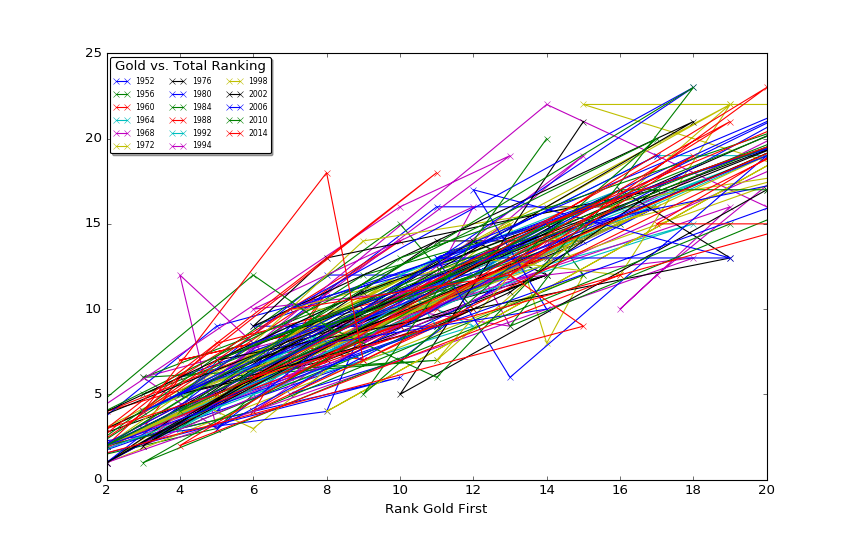

<IPython.core.display.Javascript object>


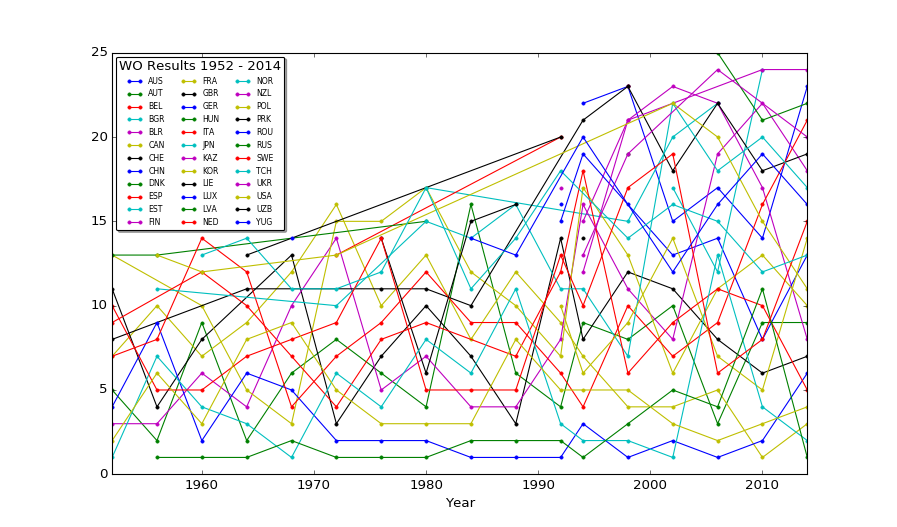

In [10]:
fig, ax = plt.subplots()
labels = []
for key, grp in data.groupby(['Year']):
    ax = grp.plot(ax=ax, kind='line', x=["Rank Gold First"], y = ["Rank Total"], marker = 'x')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left', fontsize = 'xx-small', shadow=True, title="Gold vs. Total Ranking",fancybox=True, ncol=3)

fig, ax = plt.subplots()
labels = []
for key, grp in data.groupby(['Code']):
    ax = grp.plot(ax=ax, kind='line', x=['Year'], y = ['Rank ' + 'Gold First'], marker = '.')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left', fontsize = 'xx-small', shadow=True, title="WO Results 1952 - 2014",fancybox=True, ncol=3)

In [14]:
import plotly.graph_objs as go
import plotly.offline as of 
from plotly import tools
from itertools import cycle

of.init_notebook_mode(connected=True)


li = []
cycol = cycle('bgrcmk').next
for key, grp in data.groupby(['Code']):
    trace = go.Scatter(x = grp['Year'], 
                        y = grp['Rank ' + 'Gold First'],
                        name = key,
                        line = dict(color = cycol()),
                        opacity = 0.8)
    li.append(trace)

    
layout = go.Layout(yaxis=dict(title='Rank ' + 'Gold First'), xaxis=dict(title='Year'))    
fig = go.Figure(data=li, layout=layout)
of.plot(fig, filename='./Results.html')

'file:///Users/nimadarabi/Pandas/fagkveld_ml/Olympics/Results.html'

<IPython.core.display.Javascript object>


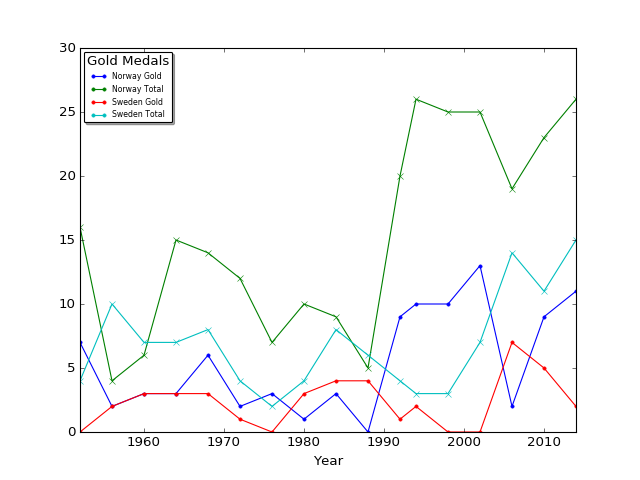

In [15]:
countries = ["Norway", "Sweden"]
medals = ["Gold", "Total"]
markers = [".", "x"]

fig, ax = plt.subplots()
labels = []
for key, grp in data[data["Country_y"].isin(countries)].groupby(["Country_y"]):
    for i in range(2) :
        ax = grp.plot(ax=ax, kind='line', x=['Year'], y = [medals[i]], marker = markers[i])
        labels.append(key+' ' + medals[i])
    #lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left', fontsize = 'xx-small', shadow=True, title="Gold Medals",fancybox=True, ncol=1)

<h1>3. Machine Learning</h1>

In [ ]:
# Feeding the model dummy values        
X = np.array([[0,0,1],
              [0,1,1],
              [1,0,1],
              [1,1,1]])
                
y = np.array([[0],[1],[1],[0]])

# Feeding the model our data
X = data[['GDP', 'Elevation','Temperature']].as_matrix() # choose features
y = data [['Total']].as_matrix()                         # Target

In [ ]:
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

np.random.seed(1)

# initialize zero-mean
syn0 = 2*np.random.random((3,4)) - 1
syn1 = 2*np.random.random((4,1)) - 1

for j in xrange(60000):
    # Feed forward through layers 0, 1, and 2
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))
    l2 = nonlin(np.dot(l1,syn1))
  
    l2_error = y - l2 # how much did we miss the target value?
    
    if (j% 10000) == 0: print "Error:" + str(np.mean(np.abs(l2_error)))
        
    l2_delta = l2_error*nonlin(l2,deriv=True)     # in what direction is the target value?
    l1_error = l2_delta.dot(syn1.T)     # how much did each l1 value contribute to the l2 error?
    l1_delta = l1_error * nonlin(l1,deriv=True) # in what direction is the target l1?

    syn1 += l1.T.dot(l2_delta)
    syn0 += l0.T.dot(l1_delta)

<h1>4. Conclusion</h1>

In [ ]:
goldmedal = "/Users/nimadarabi/Pandas/fagkveld_ml/Olympics/pix/Gold.jpg"
silvermedal = "/Users/nimadarabi/Pandas/fagkveld_ml/Olympics/pix/Silver.jpg"
bronzemedal = "/Users/nimadarabi/Pandas/fagkveld_ml/Olympics/pix/Bronze.jpg"

Image(goldmedal, width = 300)
Image(silvermedal)
Image(bronzemedal)

Previous work - Conclusion:

"YPast success is a good predictor of future success in the Olympic Games, and the bigger, better-off countries are almost guaranteed to do well given the socioeconomic advantages they enjoy, but it should be remembered that a certain level of unpredictability remains in any sporting competition," the authors wrote. "The history of the Olympic Games is full of surprising performances by individual athletes, and we should expect to see more of them in Rio in August."

http://www.kdnuggets.com/2014/01/data-mining-predict-sochi-winter-olympics-medal-counts.html

https://phys.org/news/2016-06-olympic-medals.html